<a href="https://colab.research.google.com/github/Alf-caput/P4_AlgoritmoGenetico/blob/dev3/P4_AlgGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRÁCTICA 4: Algoritmo genético

### Ana Robledano, Miguel Egido, Alfredo Robledano.

1.- Encontrar los máximos de la función "picos"

$$z = f(x,y) = 3(1-x)^2e^{-(x^2)-(y+1)^2}-10(x/5-x^3-y^5)e^{-x^2-y^2}-1/3e^{-(x+1)^2-y^2}$$

En el dominio $$\{x,y\} \in [-100,100]$$


In [1]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.8 MB/s eta 0:00:00


In [2]:
import random
from deap import base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

random.seed(42)

VALID_RANGE = (-100, 100)
INDIVIDUAL_SIZE = 2
# Para representar números del dominio [-100,100] se necesitan 8 bits y como tenemos x e y,
# Necesitaríamos 16 bits en total. El tamaño de la población más adecuado está entre [l, 2l]
# Usaremos 2*16 = 32 para mayor precisión
POPULATION_SIZE = 32

toolbox = base.Toolbox()

toolbox.register("attr_uniform", random.uniform, *VALID_RANGE)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_uniform, INDIVIDUAL_SIZE)
toolbox.register("population", tools.initRepeat, list, toolbox.individual, POPULATION_SIZE)

Definimos la función del enunciado:

In [3]:
import math
from functools import partial

F = lambda x, y: 3*(1-x)**2*math.exp(-(x**2)-(y+1)**2)-10*(x/5-x**3-y**5)*math.exp(-x**2-y**2)-1/3*math.exp(-(x+1)**2-y**2)

def evaluate_fit(individual, target_function, gene_range):
    for gene in individual:
        if not (gene_range[0] <= gene <= gene_range[1]):
            return -1,
    return target_function(*individual),

toolbox.register("evaluate", partial(evaluate_fit, target_function=F, gene_range=VALID_RANGE))

Evaluamos y representamos los valores obtenidos:

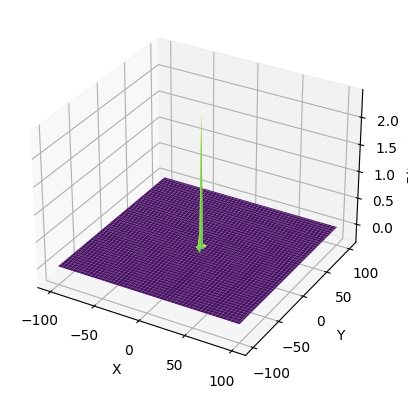

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define la función
F = lambda x, y: 3*(1-x)**2 * np.exp(-(x**2)-(y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2-y**2)

# Crea datos para la gráfica
x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100)
x, y = np.meshgrid(x, y)
z = F(x, y)

# Crea la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica la función
ax.plot_surface(x, y, z, cmap='viridis')

# Añade etiquetas
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('F(X, Y)')

# Muestra la gráfica
plt.show()


Observamos que la función alcanza un máximo absoluto en para lo valores centrales de x e y; con z = 1.5. Por ello, vamos a restringir los límites de la gráfica y tomar un sub dominio, que usaremos para producir individuos aleatorios, que inicien en valores centrales de x e y.

Text(0.5, 0.5, 'Y')

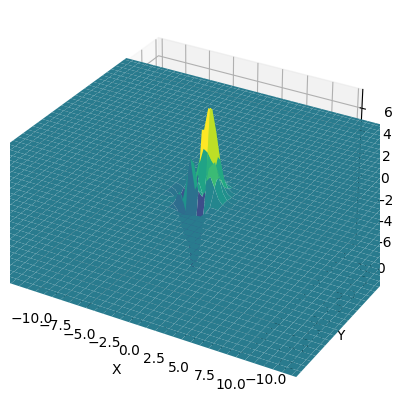

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define la función
F = lambda x, y: 3*(1-x)**2 * np.exp(-(x**2)-(y+1)**2) - 10*(x/5-x**3-y**5)*np.exp(-x**2-y**2) - 1/3*np.exp(-(x+1)**2-y**2)

# Crea datos para la gráfica
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
x, y = np.meshgrid(x, y)
z = F(x, y)

# Crea la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grafica la función
ax.plot_surface(x, y, z, cmap='viridis')

# Ajusta los límites de los ejes
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

# Añade etiquetas
ax.set_xlabel('X')
ax.set_ylabel('Y')


Vemos que hay un mínimo y tres máximos, dos locales y uno global.

## Incorporar los operadores genéticos

Preparamos los valores iniciales y constantes que usaremos para el algoritmo.

* **Selección**:`selection`. Procedimiento por el cual se seleccionan los individuos que participarán en las operaciones de cruce y mutación. Procedimiento siempre **elitista**: Un individuo tendrá mayor probabilidad de dejar descendencia si su `fitness` es más adecuado al problema de optimización (razonamiento en línea con la teoría evolutiva de Darwin) -> Las probabilidades de dejar descendencia en las futuras generaciones crecen cuando crece la adaptación del individuo al medio. **OJO CON LOS SUPERINDIVIDUOS**
* **Cruce**: `mate`. Operación probabilística que permite que dos individuos seleccionados **crucen** o **intercambien** su información genética para crear dos nuevos individuos
* **Mutación**: `mutation`. Operación probabilística que permite que un individuo seleccionado **modifique** su información genética para crear un nuevo individuo.

Ni para la probabilidad de cruce ni para la de mutación existen valores óptimos que sirva para todos los problemas. Tendrán que ajustarse a cada problema.

Destacar que tanto el **cruce** como la **mutación** son el **motor para explorar y explotar zonas del espacio de búsqueda**.

In [14]:
MU = 0      # mean
SIGMA = 5   # standard deviation
INDPB = 0.1 # indep<+ate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=MU, sigma=SIGMA, indpb=INDPB)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

In [ ]:
from deap import algorithms
import numpy as np

CXPB = 0.5  # probability of mating 2 individuals
MUTPB = 0.2 # probabilty of mutating an individual
NGEN = 20   # number of generations

pop = toolbox.population()
print(type(pop))

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB, ngen=NGEN, stats=stats, halloffame=hof, verbose=True)

<class 'list'>
gen	nevals	avg          	std	min          	max
0  	32    	-2.16768e-285	0  	-6.93659e-284	0  
1  	19    	0            	0  	0            	0  
2  	27    	-1.44113e-130	8.02388e-130	-4.61162e-129	0  
3  	17    	0            	0           	0            	0  
4  	20    	0            	0           	0            	0  
5  	19    	0            	0           	0            	0  
6  	18    	0            	0           	0            	0  
7  	17    	0            	0           	0            	0  
8  	20    	0            	0           	0            	0  
9  	13    	0            	0           	0            	0  
10 	20    	0            	0           	0            	0  
11 	21    	0            	0           	0            	0  
12 	18    	0            	0           	0            	0  
13 	23    	0            	0           	0            	0  
14 	18    	0            	0           	0            	0  
15 	18    	0            	0           	0            	0  
16 	19    	-0.03125     	0.173993    	-1           	0  
17 	

2.- Dada la [Función de Rastringin](https://en.wikipedia.org/wiki/Rastrigin_function#:~:text=In%20mathematical%20optimization%2C%20the%20Rastrigin,has%20been%20generalized%20by%20Rudolph.), con A = 10 y  $$\{xi\} \in [-5.12,5.12]$$

Implementa dicha función en Python y minimízala para n=10

Compara el funcionamiento del Algoritmo Genético para cruce con un punto con cruce con dos puntos

### Instalación de librerías para resolver Algoritmos Genéticos con Python

In [ ]:
#!pip install deap
#!pip install matplotlib
#!pip install numpy
#!pip install scipy
#!pip install scoop